# User Funnel Analysis - Exploratory Notebook

This notebook provides an interactive environment for exploring user funnel data and testing different analysis approaches.

In [29]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from analysis.funnel_analyzer import FunnelAnalyzer

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

## 1. Load and Explore Data

In [30]:
# Initialize analyzer
analyzer = FunnelAnalyzer()

# Load your data here
# analyzer.load_data('../data/your_funnel_data.csv')

# For demonstration, create sample data with 10k users
def create_sample_data():
    np.random.seed(42)
    users = range(1, 10001)  # 10,000 users
    events = []
    sources = ['organic', 'paid', 'social', 'email', 'direct']
    devices = ['desktop', 'mobile', 'tablet']
    
    for user in users:
        source = np.random.choice(sources)
        device = np.random.choice(devices)
        start_date = pd.Timestamp('2024-01-01') + pd.Timedelta(days=np.random.randint(0, 90))
        
        events.append({
            'user_id': user,
            'event': 'page_view',
            'timestamp': start_date,
            'source': source,
            'device': device
        })
        
        if np.random.random() < 0.65:
            events.append({
                'user_id': user,
                'event': 'signup',
                'timestamp': events[-1]['timestamp'] + pd.Timedelta(minutes=np.random.randint(1, 120)),
                'source': source,
                'device': device
            })
            
            if np.random.random() < 0.35:
                events.append({
                    'user_id': user,
                    'event': 'first_purchase',
                    'timestamp': events[-1]['timestamp'] + pd.Timedelta(hours=np.random.randint(1, 72)),
                    'source': source,
                    'device': device
                })
                
                if np.random.random() < 0.30:
                    events.append({
                        'user_id': user,
                        'event': 'repeat_purchase',
                        'timestamp': events[-1]['timestamp'] + pd.Timedelta(days=np.random.randint(1, 21)),
                        'source': source,
                        'device': device
                    })
    
    return pd.DataFrame(events)

# Load sample data
analyzer.data = create_sample_data()
print(f"Sample data created: {len(analyzer.data)} events from 10,000 users")
print(f"Data shape: {analyzer.data.shape}")
analyzer.data.head()

Sample data created: 19549 events from 10,000 users
Data shape: (19549, 5)


,user_id,event,timestamp,source,device
0,1,page_view,2024-01-15 00:00:00,email,desktop
1,2,page_view,2024-03-23 00:00:00,direct,desktop
2,2,signup,2024-03-23 01:15:00,direct,desktop
3,3,page_view,2024-01-22 00:00:00,email,tablet
4,3,signup,2024-01-22 01:28:00,email,tablet


## 2. Data Preprocessing

In [31]:
# Preprocess the data
analyzer.preprocess_data()

# Explore the data structure
print("Data Info:")
print(analyzer.data.info())
print("\nEvent Distribution:")
print(analyzer.data['event'].value_counts())
print("\nSource Distribution:")
print(analyzer.data['source'].value_counts())
print("\nDevice Distribution:")
print(analyzer.data['device'].value_counts())

Data preprocessing completed
Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19549 entries, 0 to 19548
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   user_id    19549 non-null  int64         
 1   event      19549 non-null  object        
 2   timestamp  19549 non-null  datetime64[ns]
 3   source     19549 non-null  object        
 4   device     19549 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 763.8+ KB
None

Event Distribution:
event
page_view          10000
signup              6578
first_purchase      2294
repeat_purchase      677
Name: count, dtype: int64

Source Distribution:
source
paid       3989
direct     3976
organic    3931
email      3858
social     3795
Name: count, dtype: int64

Device Distribution:
device
tablet     6546
mobile     6519
desktop    6484
Name: count, dtype: int64


## 3. Funnel Analysis

In [32]:
# Define funnel steps
funnel_steps = ['page_view', 'signup', 'first_purchase', 'repeat_purchase']

# Create funnel analysis
funnel_data = analyzer.create_funnel_analysis(funnel_steps)
print("Funnel Analysis Results:")
print(funnel_data)

Funnel Analysis Results:
              step  count  conversion_rate  step_conversion
0        page_view  10000           100.00       100.000000
1           signup   6578            65.78        65.780000
2   first_purchase   2294            22.94        34.873822
3  repeat_purchase    677             6.77        29.511770


## 4. Visualizations

In [33]:
# Create funnel chart
funnel_chart = analyzer.plot_funnel_chart("10K User Conversion Funnel")
funnel_chart.show()

In [ ]:
import plotly.io as pio
from IPython.display import Image, display
pio.write_image(funnel_chart, '../outputs/charts/funnel_chart.png')
display(Image('../outputs/charts/funnel_chart.png'))

In [ ]:
# Create conversion rate charts
conversion_chart = analyzer.plot_conversion_rates()
conversion_chart.show()

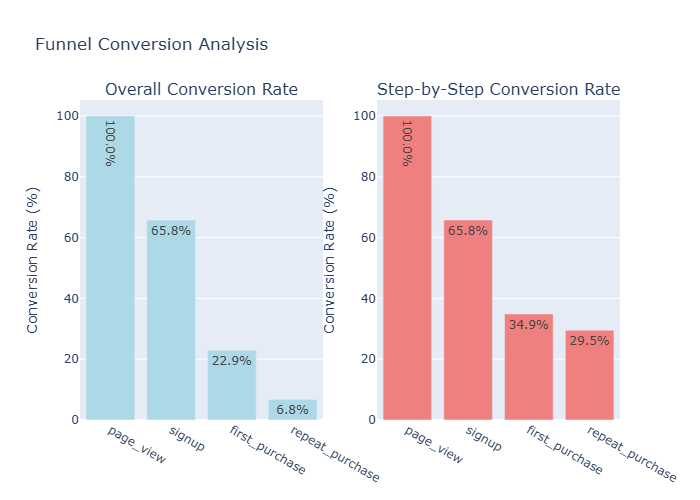

In [ ]:
import plotly.io as pio
from IPython.display import Image, display
pio.write_image(conversion_chart, '../outputs/charts/conversion_rates.png')
display(Image('../outputs/charts/conversion_rates.png'))

## 5. Advanced Analysis

In [ ]:
# Time-based analysis
analyzer.data['date'] = analyzer.data['timestamp'].dt.date
daily_events = analyzer.data.groupby(['date', 'event']).size().unstack(fill_value=0)

# Plot daily event trends
fig = px.line(daily_events.reset_index(), x='date', y=daily_events.columns,
              title='Daily Event Trends (10K Users)')
fig.show()

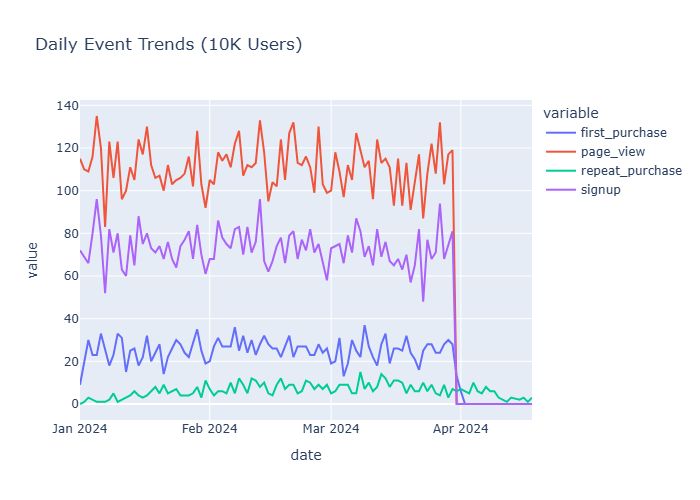

In [ ]:
import plotly.io as pio
from IPython.display import Image, display
pio.write_image(fig, '../outputs/charts/daily_trends.png')
display(Image('../outputs/charts/daily_trends.png'))

In [ ]:
# User journey analysis
user_journeys = analyzer.data.groupby('user_id')['event'].apply(list).reset_index()
user_journeys['journey_length'] = user_journeys['event'].apply(len)

print("Journey Length Distribution:")
print(user_journeys['journey_length'].value_counts().sort_index())

# Plot journey length distribution
fig = px.histogram(user_journeys, x='journey_length', 
                   title='User Journey Length Distribution (10K Users)',
                   nbins=10)
fig.show()

Journey Length Distribution:
journey_length
1    3422
2    4284
3    1617
4     677
Name: count, dtype: int64


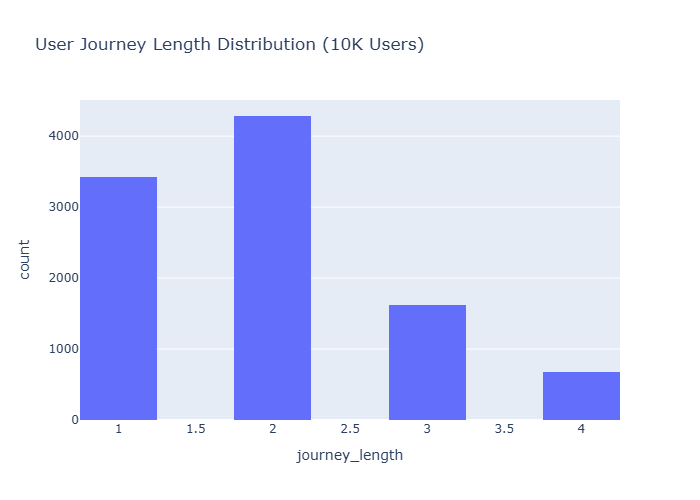

In [ ]:
import plotly.io as pio
from IPython.display import Image, display
pio.write_image(fig, '../outputs/charts/journey_length_distribution.png')
display(Image('../outputs/charts/journey_length_distribution.png'))

In [ ]:
# Source performance analysis
source_funnel = analyzer.data.groupby(['source', 'event']).size().unstack(fill_value=0)
source_funnel['conversion_rate'] = (source_funnel['first_purchase'] / source_funnel['page_view'] * 100).round(2)

print("Conversion Rate by Source:")
print(source_funnel[['page_view', 'signup', 'first_purchase', 'conversion_rate']].sort_values('conversion_rate', ascending=False))

# Plot source performance
fig = px.bar(source_funnel.reset_index(), x='source', y='conversion_rate',
             title='Conversion Rate by Traffic Source')
fig.show()

Conversion Rate by Source:
event    page_view  signup  first_purchase  conversion_rate
source                                                     
paid          2016    1339             490            24.31
organic       2001    1321             464            23.19
direct        2032    1343             471            23.18
email         1994    1291             445            22.32
social        1957    1284             424            21.67


In [ ]:
# Device performance analysis
device_funnel = analyzer.data.groupby(['device', 'event']).size().unstack(fill_value=0)
device_funnel['conversion_rate'] = (device_funnel['first_purchase'] / device_funnel['page_view'] * 100).round(2)

print("Conversion Rate by Device:")
print(device_funnel[['page_view', 'signup', 'first_purchase', 'conversion_rate']].sort_values('conversion_rate', ascending=False))

# Plot device performance
fig = px.bar(device_funnel.reset_index(), x='device', y='conversion_rate',
             title='Conversion Rate by Device Type')
fig.show()

Conversion Rate by Device:
event    page_view  signup  first_purchase  conversion_rate
device                                                     
mobile        3307    2201             786            23.77
tablet        3341    2199             779            23.32
desktop       3352    2178             729            21.75
